# Data Understanding - NYC Taxi Trip Records

Este notebook contiene el análisis exploratorio de los datos de viajes de taxi de NYC.

## Objetivos:
1. Explorar la estructura de los archivos Parquet
2. Analizar las variables disponibles por año
3. Identificar cambios en esquemas a través del tiempo
4. Determinar estrategias de consolidación de datos
5. Analizar calidad y completitud de datos

In [2]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

## 1. Exploración de Archivos y Estructura

In [3]:
# Definir ruta de datos
data_path = Path('../data/01_raw/archive')

# Obtener lista de todos los archivos parquet
parquet_files = sorted([f for f in os.listdir(data_path) if f.endswith('.parquet')])

print(f"Total de archivos Parquet encontrados: {len(parquet_files)}")
print(f"Rango de fechas: {parquet_files[0]} - {parquet_files[-1]}")
print("\nPrimeros 10 archivos:")
for f in parquet_files[:10]:
    print(f"  {f}")
print("...")
print("Últimos 5 archivos:")
for f in parquet_files[-5:]:
    print(f"  {f}")

Total de archivos Parquet encontrados: 171
Rango de fechas: yellow_tripdata_2009-01.parquet - yellow_tripdata_2023-03.parquet

Primeros 10 archivos:
  yellow_tripdata_2009-01.parquet
  yellow_tripdata_2009-02.parquet
  yellow_tripdata_2009-03.parquet
  yellow_tripdata_2009-04.parquet
  yellow_tripdata_2009-05.parquet
  yellow_tripdata_2009-06.parquet
  yellow_tripdata_2009-07.parquet
  yellow_tripdata_2009-08.parquet
  yellow_tripdata_2009-09.parquet
  yellow_tripdata_2009-10.parquet
...
Últimos 5 archivos:
  yellow_tripdata_2022-11.parquet
  yellow_tripdata_2022-12.parquet
  yellow_tripdata_2023-01.parquet
  yellow_tripdata_2023-02.parquet
  yellow_tripdata_2023-03.parquet


In [4]:
# Analizar años y meses disponibles
years = defaultdict(list)
for f in parquet_files:
    parts = f.replace('.parquet', '').split('_')
    if len(parts) >= 3:
        year_month = parts[2]
        year = year_month.split('-')[0]
        month = year_month.split('-')[1]
        years[year].append(month)

print("Distribución por años:")
for year in sorted(years.keys()):
    months = sorted(years[year])
    print(f"  {year}: {len(months)} archivos - Meses: {', '.join(months)}")

Distribución por años:
  2009: 12 archivos - Meses: 01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 12
  2010: 12 archivos - Meses: 01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 12
  2011: 12 archivos - Meses: 01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 12
  2012: 12 archivos - Meses: 01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 12
  2013: 12 archivos - Meses: 01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 12
  2014: 12 archivos - Meses: 01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 12
  2015: 12 archivos - Meses: 01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 12
  2016: 12 archivos - Meses: 01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 12
  2017: 12 archivos - Meses: 01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 12
  2018: 12 archivos - Meses: 01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 12
  2019: 12 archivos - Meses: 01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 12
  2020: 12 archivos - Meses: 01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 12
  2021: 12 archivos - Meses: 01, 02, 03, 04, 05, 06, 07, 08, 09, 

## 2. Análisis de Esquemas y Variables

In [5]:
def get_schema_info(file_path):
    """Extrae información del esquema de un archivo parquet"""
    try:
        table = pq.read_table(file_path)
        schema = table.schema
        
        columns_info = []
        for i, field in enumerate(schema):
            columns_info.append({
                'name': field.name,
                'type': str(field.type),
                'nullable': field.nullable
            })
        
        return {
            'num_rows': table.num_rows,
            'num_columns': table.num_columns,
            'columns': columns_info,
            'file_size_mb': os.path.getsize(file_path) / (1024 * 1024)
        }
    except Exception as e:
        print(f"Error procesando {file_path}: {e}")
        return None

In [6]:
# Analizar esquemas de archivos representativos (uno por año)
sample_files = []
analyzed_years = set()

for f in parquet_files:
    year = f.split('_')[2].split('-')[0]
    if year not in analyzed_years:
        sample_files.append(f)
        analyzed_years.add(year)

print(f"Analizando {len(sample_files)} archivos representativos...")

schemas_analysis = {}
for f in sample_files:
    file_path = data_path / f
    year = f.split('_')[2].split('-')[0]
    
    print(f"Procesando {f}...")
    schema_info = get_schema_info(file_path)
    
    if schema_info:
        schemas_analysis[year] = {
            'file': f,
            'schema': schema_info
        }
        print(f"  - {schema_info['num_rows']:,} filas, {schema_info['num_columns']} columnas, {schema_info['file_size_mb']:.1f} MB")

Analizando 15 archivos representativos...
Procesando yellow_tripdata_2009-01.parquet...
  - 14,092,413 filas, 18 columnas, 448.0 MB
Procesando yellow_tripdata_2010-01.parquet...
  - 14,863,778 filas, 18 columnas, 491.5 MB
Procesando yellow_tripdata_2011-01.parquet...
  - 13,464,997 filas, 19 columnas, 159.4 MB
Procesando yellow_tripdata_2012-01.parquet...
  - 13,058,348 filas, 19 columnas, 159.1 MB
Procesando yellow_tripdata_2013-01.parquet...
  - 14,776,617 filas, 19 columnas, 176.2 MB
Procesando yellow_tripdata_2014-01.parquet...
  - 13,782,517 filas, 19 columnas, 164.0 MB
Procesando yellow_tripdata_2015-01.parquet...
  - 12,741,035 filas, 19 columnas, 167.2 MB
Procesando yellow_tripdata_2016-01.parquet...
  - 10,905,067 filas, 19 columnas, 144.2 MB
Procesando yellow_tripdata_2017-01.parquet...
  - 9,710,820 filas, 19 columnas, 128.6 MB
Procesando yellow_tripdata_2018-01.parquet...
  - 8,760,687 filas, 19 columnas, 117.9 MB
Procesando yellow_tripdata_2019-01.parquet...
  - 7,696,617 

In [7]:
# Comparar esquemas entre años
print("\n=== ANÁLISIS DETALLADO DE ESQUEMAS POR AÑO ===\n")

all_columns = set()
column_by_year = defaultdict(list)

for year in sorted(schemas_analysis.keys()):
    schema = schemas_analysis[year]['schema']
    print(f"AÑO {year} - {schemas_analysis[year]['file']}")
    print(f"  Filas: {schema['num_rows']:,}")
    print(f"  Columnas: {schema['num_columns']}")
    print(f"  Tamaño: {schema['file_size_mb']:.1f} MB")
    print("  Variables:")
    
    year_columns = []
    for col in schema['columns']:
        print(f"    - {col['name']}: {col['type']} ({'nullable' if col['nullable'] else 'not null'})")
        all_columns.add(col['name'])
        year_columns.append(col['name'])
    
    column_by_year[year] = year_columns
    print()


=== ANÁLISIS DETALLADO DE ESQUEMAS POR AÑO ===

AÑO 2009 - yellow_tripdata_2009-01.parquet
  Filas: 14,092,413
  Columnas: 18
  Tamaño: 448.0 MB
  Variables:
    - vendor_name: string (nullable)
    - Trip_Pickup_DateTime: string (nullable)
    - Trip_Dropoff_DateTime: string (nullable)
    - Passenger_Count: int64 (nullable)
    - Trip_Distance: double (nullable)
    - Start_Lon: double (nullable)
    - Start_Lat: double (nullable)
    - Rate_Code: double (nullable)
    - store_and_forward: double (nullable)
    - End_Lon: double (nullable)
    - End_Lat: double (nullable)
    - Payment_Type: string (nullable)
    - Fare_Amt: double (nullable)
    - surcharge: double (nullable)
    - mta_tax: double (nullable)
    - Tip_Amt: double (nullable)
    - Tolls_Amt: double (nullable)
    - Total_Amt: double (nullable)

AÑO 2010 - yellow_tripdata_2010-01.parquet
  Filas: 14,863,778
  Columnas: 18
  Tamaño: 491.5 MB
  Variables:
    - vendor_id: string (nullable)
    - pickup_datetime: string

In [8]:
# Crear matriz de variables por año
print("\n=== MATRIZ DE VARIABLES POR AÑO ===\n")

# Crear DataFrame para visualizar qué variables están en cada año
variable_matrix = pd.DataFrame(index=sorted(all_columns))

for year in sorted(schemas_analysis.keys()):
    year_vars = column_by_year[year]
    variable_matrix[year] = variable_matrix.index.isin(year_vars)

# Mostrar la matriz
print("Variables por año (True = presente, False = ausente):")
print(variable_matrix.to_string())

# Análisis de consistencia
print("\n=== ANÁLISIS DE CONSISTENCIA DE VARIABLES ===\n")

# Variables que están en todos los años
consistent_vars = variable_matrix.all(axis=1)
always_present = consistent_vars[consistent_vars].index.tolist()

print(f"Variables presentes en TODOS los años ({len(always_present)}):")
for var in always_present:
    print(f"  - {var}")

# Variables que cambiaron
inconsistent_vars = ~variable_matrix.all(axis=1) & variable_matrix.any(axis=1)
changed_vars = inconsistent_vars[inconsistent_vars].index.tolist()

print(f"\nVariables que cambiaron a lo largo del tiempo ({len(changed_vars)}):")
for var in changed_vars:
    present_years = variable_matrix.loc[var][variable_matrix.loc[var]].index.tolist()
    print(f"  - {var}: presente en {present_years}")


=== MATRIZ DE VARIABLES POR AÑO ===

Variables por año (True = presente, False = ausente):
                        2009   2010   2011   2012   2013   2014   2015   2016   2017   2018   2019   2020   2021   2022   2023
DOLocationID           False  False   True   True   True   True   True   True   True   True   True   True   True   True   True
End_Lat                 True  False  False  False  False  False  False  False  False  False  False  False  False  False  False
End_Lon                 True  False  False  False  False  False  False  False  False  False  False  False  False  False  False
Fare_Amt                True  False  False  False  False  False  False  False  False  False  False  False  False  False  False
PULocationID           False  False   True   True   True   True   True   True   True   True   True   True   True   True   True
Passenger_Count         True  False  False  False  False  False  False  False  False  False  False  False  False  False  False
Payment_Type       

## 3. Análisis de Volumen de Datos

In [9]:
# Calcular estadísticas de todos los archivos
print("Calculando estadísticas de volumen para todos los archivos...")

file_stats = []
total_rows = 0
total_size_mb = 0

# Procesar en lotes para evitar sobrecarga de memoria
batch_size = 10
for i in range(0, len(parquet_files), batch_size):
    batch = parquet_files[i:i+batch_size]
    print(f"Procesando lote {i//batch_size + 1}/{(len(parquet_files) + batch_size - 1)//batch_size}...")
    
    for f in batch:
        file_path = data_path / f
        try:
            # Solo leer metadatos para eficiencia
            parquet_file = pq.ParquetFile(file_path)
            num_rows = parquet_file.metadata.num_rows
            file_size_mb = os.path.getsize(file_path) / (1024 * 1024)
            
            year_month = f.split('_')[2].replace('.parquet', '')
            year, month = year_month.split('-')
            
            file_stats.append({
                'file': f,
                'year': int(year),
                'month': int(month),
                'year_month': year_month,
                'rows': num_rows,
                'size_mb': file_size_mb
            })
            
            total_rows += num_rows
            total_size_mb += file_size_mb
            
        except Exception as e:
            print(f"Error procesando {f}: {e}")

# Crear DataFrame con estadísticas
stats_df = pd.DataFrame(file_stats)

print(f"\n=== RESUMEN GENERAL ===")
print(f"Total de archivos procesados: {len(stats_df)}")
print(f"Total de registros: {total_rows:,}")
print(f"Tamaño total: {total_size_mb:,.1f} MB ({total_size_mb/1024:.1f} GB)")
print(f"Promedio de registros por archivo: {total_rows/len(stats_df):,.0f}")
print(f"Promedio de tamaño por archivo: {total_size_mb/len(stats_df):.1f} MB")

Calculando estadísticas de volumen para todos los archivos...
Procesando lote 1/18...
Procesando lote 2/18...
Procesando lote 3/18...
Procesando lote 4/18...
Procesando lote 5/18...
Procesando lote 6/18...
Procesando lote 7/18...
Procesando lote 8/18...
Procesando lote 9/18...
Procesando lote 10/18...
Procesando lote 11/18...
Procesando lote 12/18...
Procesando lote 13/18...
Procesando lote 14/18...
Procesando lote 15/18...
Procesando lote 16/18...
Procesando lote 17/18...
Procesando lote 18/18...

=== RESUMEN GENERAL ===
Total de archivos procesados: 171
Total de registros: 1,708,142,581
Tamaño total: 28,457.4 MB (27.8 GB)
Promedio de registros por archivo: 9,989,138
Promedio de tamaño por archivo: 166.4 MB


In [10]:
# Análisis por año
yearly_stats = stats_df.groupby('year').agg({
    'rows': ['count', 'sum', 'mean'],
    'size_mb': ['sum', 'mean']
}).round(1)

yearly_stats.columns = ['archivos', 'total_registros', 'promedio_registros', 'total_mb', 'promedio_mb']

print("\n=== ESTADÍSTICAS POR AÑO ===")
print(yearly_stats.to_string())


=== ESTADÍSTICAS POR AÑO ===
      archivos  total_registros  promedio_registros  total_mb  promedio_mb
year                                                                      
2009        12        170896055          14241337.9    5452.6        454.4
2010        12        169001162          14083430.2    5392.6        449.4
2011        12        176887259          14740604.9    2105.9        175.5
2012        12        171359007          14279917.2    2082.6        173.6
2013        12        171816340          14318028.3    2044.6        170.4
2014        12        165447579          13787298.2    2048.7        170.7
2015        12        146039231          12169935.9    1933.2        161.1
2016        12        131131805          10927650.4    1748.1        145.7
2017        12        113500327           9458360.6    1520.8        126.7
2018        12        102871387           8572615.6    1396.6        116.4
2019        12         84598444           7049870.3    1185.9         

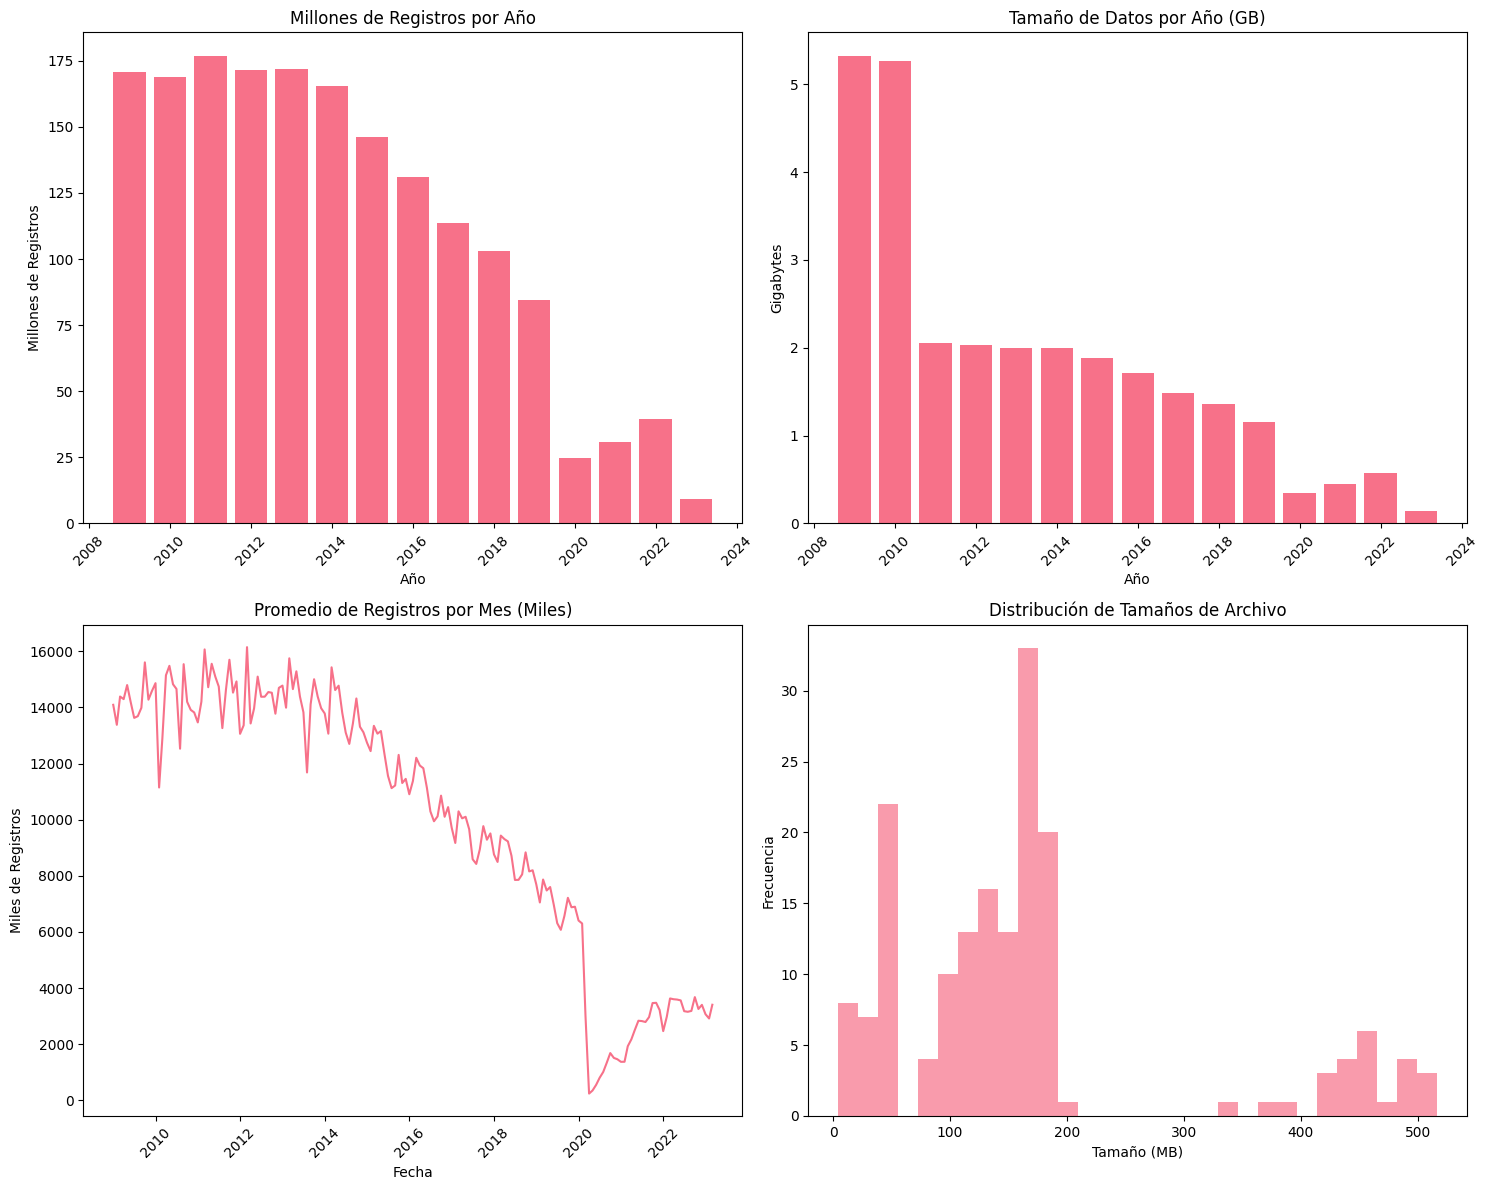

In [11]:
# Visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Gráfico 1: Número de registros por año
yearly_rows = stats_df.groupby('year')['rows'].sum()
axes[0,0].bar(yearly_rows.index, yearly_rows.values / 1e6)
axes[0,0].set_title('Millones de Registros por Año')
axes[0,0].set_xlabel('Año')
axes[0,0].set_ylabel('Millones de Registros')
axes[0,0].tick_params(axis='x', rotation=45)

# Gráfico 2: Tamaño de archivos por año
yearly_size = stats_df.groupby('year')['size_mb'].sum()
axes[0,1].bar(yearly_size.index, yearly_size.values / 1024)
axes[0,1].set_title('Tamaño de Datos por Año (GB)')
axes[0,1].set_xlabel('Año')
axes[0,1].set_ylabel('Gigabytes')
axes[0,1].tick_params(axis='x', rotation=45)

# Gráfico 3: Registros promedio por mes a través del tiempo
monthly_avg = stats_df.groupby(['year', 'month'])['rows'].mean().reset_index()
monthly_avg['date'] = pd.to_datetime(monthly_avg[['year', 'month']].assign(day=1))
axes[1,0].plot(monthly_avg['date'], monthly_avg['rows'] / 1000)
axes[1,0].set_title('Promedio de Registros por Mes (Miles)')
axes[1,0].set_xlabel('Fecha')
axes[1,0].set_ylabel('Miles de Registros')
axes[1,0].tick_params(axis='x', rotation=45)

# Gráfico 4: Distribución de tamaños de archivo
axes[1,1].hist(stats_df['size_mb'], bins=30, alpha=0.7)
axes[1,1].set_title('Distribución de Tamaños de Archivo')
axes[1,1].set_xlabel('Tamaño (MB)')
axes[1,1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

## 4. Análisis de Calidad de Datos

In [12]:
# Seleccionar algunos archivos para análisis de calidad
quality_sample_files = [
    'yellow_tripdata_2009-01.parquet',  # Primer año
    'yellow_tripdata_2015-01.parquet',  # Año medio
    'yellow_tripdata_2023-01.parquet'   # Último año
]

def analyze_data_quality(file_path, sample_size=10000):
    """Analiza calidad de datos de un archivo"""
    try:
        # Leer muestra del archivo
        df = pd.read_parquet(file_path)
        if len(df) > sample_size:
            df = df.sample(sample_size, random_state=42)
        
        quality_report = {
            'total_rows': len(df),
            'total_columns': len(df.columns),
            'missing_data': {},
            'dtypes': df.dtypes.to_dict(),
            'numeric_summary': {},
            'categorical_summary': {}
        }
        
        # Análisis de valores faltantes
        for col in df.columns:
            missing_count = df[col].isnull().sum()
            missing_pct = (missing_count / len(df)) * 100
            quality_report['missing_data'][col] = {
                'count': missing_count,
                'percentage': missing_pct
            }
        
        # Análisis de columnas numéricas
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            quality_report['numeric_summary'][col] = {
                'mean': df[col].mean(),
                'std': df[col].std(),
                'min': df[col].min(),
                'max': df[col].max(),
                'zeros': (df[col] == 0).sum(),
                'negatives': (df[col] < 0).sum()
            }
        
        # Análisis de columnas categóricas/texto
        categorical_cols = df.select_dtypes(include=['object', 'category']).columns
        for col in categorical_cols:
            quality_report['categorical_summary'][col] = {
                'unique_values': df[col].nunique(),
                'most_common': df[col].value_counts().head(5).to_dict() if len(df[col].value_counts()) > 0 else {}
            }
        
        return quality_report, df.head()
        
    except Exception as e:
        print(f"Error analizando calidad de {file_path}: {e}")
        return None, None

In [13]:
# Ejecutar análisis de calidad
quality_results = {}

for file_name in quality_sample_files:
    file_path = data_path / file_name
    if file_path.exists():
        print(f"\nAnalizando calidad de {file_name}...")
        quality_report, sample_data = analyze_data_quality(file_path)
        
        if quality_report:
            quality_results[file_name] = quality_report
            
            print(f"  - {quality_report['total_rows']} filas, {quality_report['total_columns']} columnas")
            
            # Mostrar datos faltantes
            missing_cols = [(col, info['percentage']) for col, info in quality_report['missing_data'].items() 
                           if info['percentage'] > 0]
            if missing_cols:
                print("  - Columnas con datos faltantes:")
                for col, pct in sorted(missing_cols, key=lambda x: x[1], reverse=True)[:10]:
                    print(f"    {col}: {pct:.1f}%")
            else:
                print("  - No hay datos faltantes")
            
            print("\n  Muestra de datos:")
            if sample_data is not None:
                print(sample_data.to_string(max_cols=8))
    else:
        print(f"Archivo {file_name} no encontrado")


Analizando calidad de yellow_tripdata_2009-01.parquet...
  - 10000 filas, 18 columnas
  - Columnas con datos faltantes:
    Rate_Code: 100.0%
    mta_tax: 100.0%
    store_and_forward: 100.0%

  Muestra de datos:
         vendor_name Trip_Pickup_DateTime Trip_Dropoff_DateTime  Passenger_Count  ...  mta_tax  Tip_Amt  Tolls_Amt  Total_Amt
11202719         DDS  2009-01-28 08:46:39   2009-01-28 08:49:44                1  ...      NaN      0.0       0.00       3.30
10844577         VTS  2009-01-09 20:22:00   2009-01-09 20:31:00                1  ...      NaN      0.0       0.00       7.80
1582146          CMT  2009-01-06 00:20:19   2009-01-06 00:37:46                1  ...      NaN      0.0       4.15      27.55
11702097         CMT  2009-01-11 23:09:47   2009-01-11 23:15:43                1  ...      NaN      0.0       0.00       6.20
9108471          VTS  2009-01-09 07:44:00   2009-01-09 07:48:00                1  ...      NaN      0.0       0.00       6.10

Analizando calidad de yellow_

## 5. Recomendaciones de Consolidación

In [14]:
print("=== RECOMENDACIONES DE CONSOLIDACIÓN DE DATOS ===")

# Análisis de agrupaciones por esquema
schema_groups = defaultdict(list)
for year, data in schemas_analysis.items():
    column_signature = tuple(sorted([col['name'] for col in data['schema']['columns']]))
    schema_groups[column_signature].append(year)

print(f"\n1. AGRUPACIÓN POR ESQUEMAS IDÉNTICOS:")
for i, (signature, years) in enumerate(schema_groups.items(), 1):
    print(f"\n   Grupo {i}: Años {', '.join(sorted(years))}")
    print(f"   Variables ({len(signature)}): {', '.join(signature[:10])}{'...' if len(signature) > 10 else ''}")

print(f"\n2. ESTRATEGIAS RECOMENDADAS:")

if len(always_present) > 0:
    print(f"\n   A) CONSOLIDACIÓN POR VARIABLES COMUNES:")
    print(f"      - Usar las {len(always_present)} variables que están en todos los años")
    print(f"      - Variables: {', '.join(always_present)}")
    print(f"      - Beneficio: Dataset homogéneo sin pérdida de información temporal")

print(f"\n   B) CONSOLIDACIÓN POR PERÍODOS:")
for signature, years in schema_groups.items():
    if len(years) > 1:
        total_years = len(years)
        year_range = f"{min(years)}-{max(years)}" if min(years) != max(years) else years[0]
        
        # Calcular volumen aproximado
        period_files = [f for f in parquet_files if any(f"_{y}-" in f for y in years)]
        period_rows = sum(stats_df[stats_df['year'].isin([int(y) for y in years])]['rows'])
        period_size = sum(stats_df[stats_df['year'].isin([int(y) for y in years])]['size_mb'])
        
        print(f"      - Período {year_range}: {total_years} años, {len(signature)} variables")
        print(f"        * {len(period_files)} archivos, {period_rows:,} registros, {period_size:.1f} MB")

print(f"\n   C) CONSIDERACIONES TÉCNICAS:")
print(f"      - Formato recomendado: Parquet particionado por año/mes")
print(f"      - Compresión: SNAPPY o GZIP")
print(f"      - Particionamiento: /year=YYYY/month=MM/")
print(f"      - Tamaño objetivo por partición: 100-500 MB")

print(f"\n3. PRIORIDADES DE IMPLEMENTACIÓN:")
print(f"   1. Crear dataset con variables comunes ({len(always_present)} vars)")
print(f"   2. Implementar particionamiento por fecha")
print(f"   3. Establecer pipeline de actualización incremental")
print(f"   4. Crear datasets especializados por período si es necesario")

=== RECOMENDACIONES DE CONSOLIDACIÓN DE DATOS ===

1. AGRUPACIÓN POR ESQUEMAS IDÉNTICOS:

   Grupo 1: Años 2009
   Variables (18): End_Lat, End_Lon, Fare_Amt, Passenger_Count, Payment_Type, Rate_Code, Start_Lat, Start_Lon, Tip_Amt, Tolls_Amt...

   Grupo 2: Años 2010
   Variables (18): dropoff_datetime, dropoff_latitude, dropoff_longitude, fare_amount, mta_tax, passenger_count, payment_type, pickup_datetime, pickup_latitude, pickup_longitude...

   Grupo 3: Años 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023
   Variables (19): DOLocationID, PULocationID, RatecodeID, VendorID, airport_fee, congestion_surcharge, extra, fare_amount, improvement_surcharge, mta_tax...

2. ESTRATEGIAS RECOMENDADAS:

   A) CONSOLIDACIÓN POR VARIABLES COMUNES:
      - Usar las 1 variables que están en todos los años
      - Variables: mta_tax
      - Beneficio: Dataset homogéneo sin pérdida de información temporal

   B) CONSOLIDACIÓN POR PERÍODOS:
      - Período 2011-2023: 13 añ

## 6. Resumen Ejecutivo

In [19]:
print("\n" + "="*60)
print("              RESUMEN EJECUTIVO - DATASET NYC TAXI")
print("="*60)

print(f"\n📊 VOLUMEN DE DATOS:")
# Obtener años de los archivos directamente
first_year = parquet_files[0].split('_')[2].split('-')[0]
last_year = parquet_files[-1].split('_')[2].split('-')[0]

print(f"   • {len(parquet_files)} archivos Parquet ({first_year}-{last_year})")
print(f"   • {total_rows:,} registros totales")
print(f"   • {total_size_mb/1024:.1f} GB de datos")

print(f"\n🏗️ ESTRUCTURA:")
print(f"   • {len(all_columns)} variables únicas identificadas")
print(f"   • {len(always_present)} variables presentes en todos los años")
print(f"   • {len(changed_vars)} variables con cambios temporales")
print(f"   • {len(schema_groups)} grupos de esquemas diferentes")

print(f"\n⭐ RECOMENDACIÓN PRINCIPAL:")
print(f"   1. Consolidar usando variables comunes para máxima compatibilidad")
print(f"   2. Implementar particionamiento por año/mes")
print(f"   3. Establecer pipeline de procesamiento incremental")

print(f"\n🎯 PRÓXIMOS PASOS:")
print(f"   1. Definir esquema target basado en variables comunes")
print(f"   2. Desarrollar proceso ETL de consolidación")
print(f"   3. Implementar validaciones de calidad de datos")
print(f"   4. Crear documentación de diccionario de datos")

print("\n" + "="*60)


              RESUMEN EJECUTIVO - DATASET NYC TAXI

📊 VOLUMEN DE DATOS:
   • 171 archivos Parquet (2009-2023)
   • 1,708,142,581 registros totales
   • 27.8 GB de datos

🏗️ ESTRUCTURA:
   • 44 variables únicas identificadas
   • 1 variables presentes en todos los años
   • 43 variables con cambios temporales
   • 3 grupos de esquemas diferentes

⭐ RECOMENDACIÓN PRINCIPAL:
   1. Consolidar usando variables comunes para máxima compatibilidad
   2. Implementar particionamiento por año/mes
   3. Establecer pipeline de procesamiento incremental

🎯 PRÓXIMOS PASOS:
   1. Definir esquema target basado en variables comunes
   2. Desarrollar proceso ETL de consolidación
   3. Implementar validaciones de calidad de datos
   4. Crear documentación de diccionario de datos

